In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from bs4 import BeautifulSoup
import seaborn as sns
from statsmodels.nonparametric.kernel_regression import KernelReg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [553]:
prices_data = pd.read_csv("prices_data.csv")
data_house_features = pd.read_csv("house_features.csv")
metro_data = pd.read_csv("metro_data.csv")

merged_table = pd.read_csv("merged_table.csv")
merged_table_beta = pd.read_csv("merged_table_beta.csv")

In [592]:
matched_data = pd.read_csv("matched_data18.csv")
matched_data['reportDate'] = pd.to_datetime(matched_data['reportDate'])

In [593]:
#merged_table['new_realty_id'] = pd.factorize(merged_table['realty_id'])[0] + 1

## Cleaning data for R

Я дропнул ряды с пропусками для стобцов подъезды и квартиры и заменил на 0 в столбце газоснабжение

In [550]:
merged_table_beta.isna().sum().sort_values(ascending=False).head(10)

value                                        0
reportDate                                   0
Ближайшая станция после тритмента            0
Ближайшая станция до тритмента расстояние    0
Ближайшая станция до тритмента               0
Сокращение расстояния                        0
cumprod                                      0
discounted_value                             0
Number of queries                            0
new_realty_id                                0
dtype: int64

In [ ]:
merged_table_beta["Высота потолков"] = merged_table_beta.groupby("Год постройки")["Высота потолков"].transform(lambda x: x.fillna(x.mean()))
merged_table_beta = merged_table_beta.dropna(subset=["Высота потолков"])
merged_table_beta = merged_table_beta.drop(columns = ["Строительная серия", "Фонд капитального ремонта", "Мусоропроводов", "Отопление", "Тип дома", "Газоснабжение"])
#merged_table_beta.to_csv("final_prematched_data.csv", index = False)

## LPR

In [628]:
merged_table_lpr = merged_table[merged_table["reportDate"] >= "2021-06-01"].copy()
merged_table_lpr.loc[:, "log_discounted_value"] = np.log(merged_table_lpr["discounted_value"])

merged_table_lpr['post'] = (merged_table_lpr['reportDate'] > '2024-09-01').astype(int)
lpr_data = merged_table_lpr.groupby(["post", "Сокращение расстояния"])["log_discounted_value"].median().reset_index()

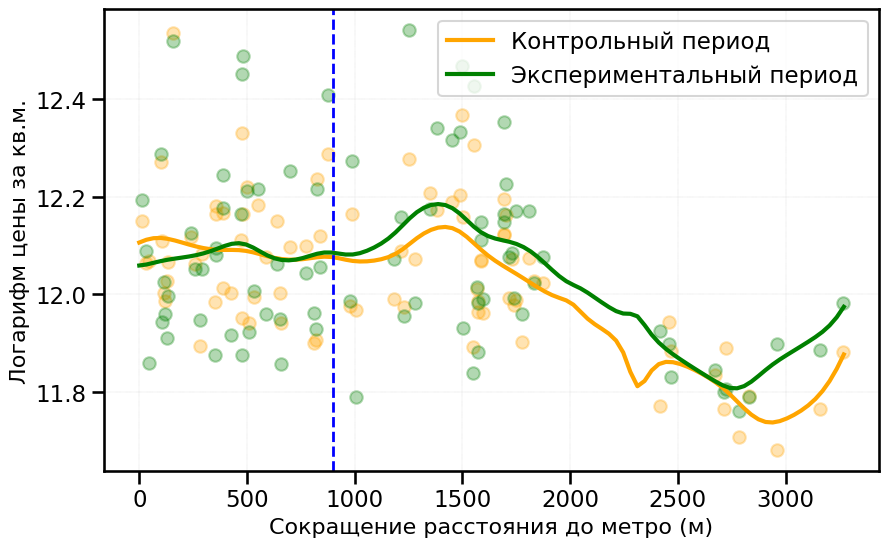

In [629]:
lpr_before = lpr_data[lpr_data["post"] == 0]
lpr_after = lpr_data[lpr_data["post"] == 1]

def local_poly_regression(lpr_data, color, label):
    kr = KernelReg(
        endog=lpr_data["log_discounted_value"], 
        exog=lpr_data["Сокращение расстояния"], 
        var_type='c', 
        reg_type='ll',  
        bw=[130]
    )
    
    distance_range = np.linspace(0, 3270, 100) 
    predicted_log_price, _ = kr.fit(distance_range)  
    
    plt.scatter(lpr_data["Сокращение расстояния"], lpr_data["log_discounted_value"], alpha=0.3, color=color, marker="o") 
    plt.plot(distance_range, predicted_log_price, color=color, label=label, linewidth=3)
sns.set_context("talk") #paper notebook  talk poster
plt.figure(figsize=(10, 6))

local_poly_regression(lpr_before, color="orange", label="Контрольный период")
local_poly_regression(lpr_after, color="green", label="Экспериментальный период")

plt.xlabel("Сокращение расстояния до метро (м)", fontsize=16)
plt.ylabel("Логарифм цены за кв.м.", fontsize=16)
#plt.title("LPR (01.06.2021 - 01.02.2025)", fontsize=22)
plt.legend()
# Проведение вертикальной линии при x = 900
plt.axvline(x=900, color="blue", linestyle="--", linewidth=2)
plt.grid(True, linestyle=":", linewidth=0.3)
plt.savefig("LPR", dpi=300)
plt.show()

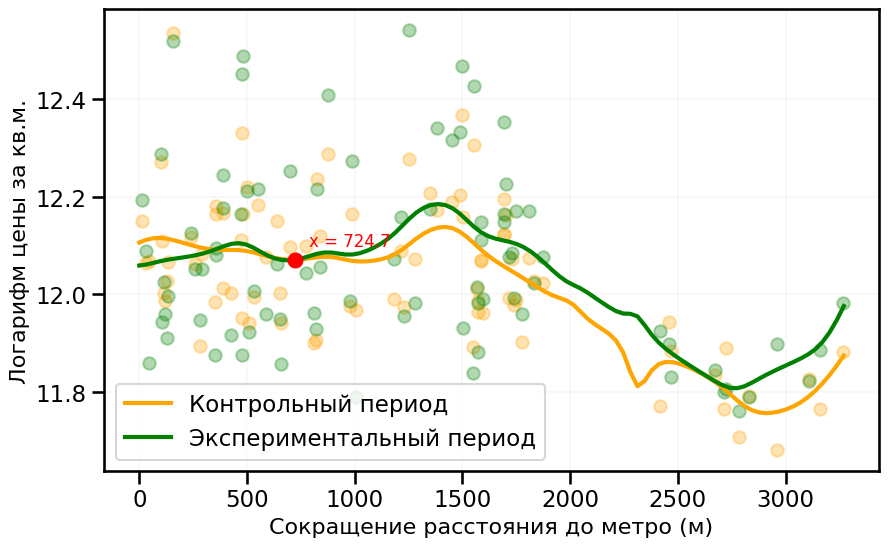

In [ ]:


# Предполагается, что у вас уже загружен DataFrame lpr_data с колонками:
# "post", "log_discounted_value", "Сокращение расстояния"

# Разбиваем данные на контрольный (post==0) и экспериментальный (post==1) периоды
lpr_before = lpr_data[lpr_data["post"] == 0]
lpr_after = lpr_data[lpr_data["post"] == 1]

def local_poly_regression(lpr_data, color, label):
    # Создаем объект KernelReg для локальной полиномиальной регрессии
    kr = KernelReg(
        endog=lpr_data["log_discounted_value"],
        exog=lpr_data["Сокращение расстояния"],
        var_type='c',
        reg_type='ll',
        bw=[130]
    )
    # Определяем общий диапазон значений по оси X
    distance_range = np.linspace(0, 3270, 100)
    # Получаем предсказания
    predicted_log_price, _ = kr.fit(distance_range)
    
    # Строим scatter-график исходных данных и линию регрессии
    plt.scatter(lpr_data["Сокращение расстояния"], lpr_data["log_discounted_value"],
                alpha=0.3, color=color, marker="o")
    plt.plot(distance_range, predicted_log_price, color=color, label=label, linewidth=3)
    
    # Возвращаем объект регрессии и диапазон значений
    return kr, distance_range

sns.set_context("talk")  # варианты: paper, notebook, talk, poster
plt.figure(figsize=(10, 6))

# Строим кривые для контрольного и экспериментального периодов
kr_before, distance_range = local_poly_regression(lpr_before, color="orange", label="Контрольный период")
kr_after, _ = local_poly_regression(lpr_after, color="green", label="Экспериментальный период")

# Вычисляем предсказанные значения для обоих периодов по общему диапазону
pred_before, _ = kr_before.fit(distance_range)
pred_after, _ = kr_after.fit(distance_range)

# Вычисляем разность между предсказанными значениями
diff = pred_before - pred_after

# Находим все индексы, где разность меняет знак (т.е. линии пересекаются)
indices = np.where(np.diff(np.sign(diff)))[0][[-1]]

# Для каждого найденного индекса определяем точку пересечения
for idx in indices:
    # Интерполируем для более точного определения точки пересечения
    x1, x2 = distance_range[idx], distance_range[idx+1]
    y1_diff, y2_diff = diff[idx], diff[idx+1]
    intersect_x = x1 - y1_diff * (x2 - x1) / (y2_diff - y1_diff)
    # Определяем y в точке пересечения (например, по контрольной линии)
    intersect_y, _ = kr_before.fit([intersect_x])
    
    # Отмечаем точку на графике
    plt.scatter(intersect_x, intersect_y, color="red", s=100, zorder=5)
    # Подписываем точку: подписываем только значение x
    plt.annotate(f"x = {intersect_x:.1f}", (intersect_x, intersect_y),
                 textcoords="offset points", xytext=(10,10), fontsize=12, color="red")

plt.xlabel("Сокращение расстояния до метро (м)", fontsize=16)
plt.ylabel("Логарифм цены за кв.м.", fontsize=16)
plt.legend()
plt.grid(True, linestyle=":", linewidth=0.3)
plt.savefig("LPR", dpi=300)
plt.show()


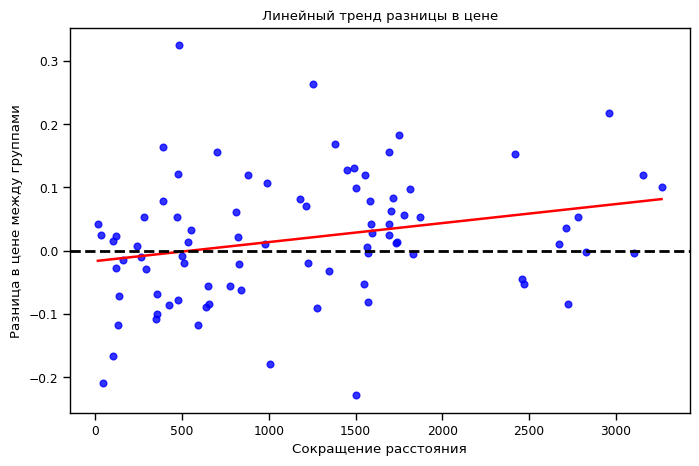

In [ ]:
# Создаем сводную таблицу, где по строкам — "Сокращение расстояния", а столбцы — "post" (0 и 1)
pivot = lpr_data.pivot_table(index="Сокращение расстояния", columns="post", values="log_discounted_value")

# Вычисляем разницу между post=1 и post=0
pivot["price_difference"] = pivot[1] - pivot[0]


plt.figure(figsize=(8, 5))

# Точечный график + линия регрессии
sns.regplot(data=pivot, x=pivot.index, y="price_difference", scatter=True, ci=None, color="blue", line_kws={"color": "red"})
plt.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
plt.xlabel("Сокращение расстояния")
plt.ylabel("Разница в цене между группами")
plt.title("Линейный тренд разницы в цене")

plt.show()

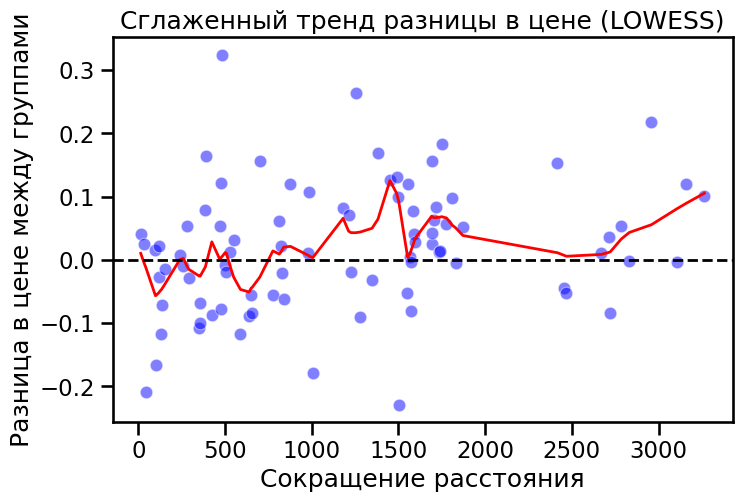

In [ ]:
plt.figure(figsize=(8, 5))

lowess = sm.nonparametric.lowess(pivot["price_difference"], pivot.index, frac=0.12)


sns.scatterplot(data=pivot, x=pivot.index, y="price_difference", color="blue", alpha=0.5)

plt.plot(lowess[:, 0], lowess[:, 1], color="red", linewidth=2)
plt.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
plt.xlabel("Сокращение расстояния")
plt.ylabel("Разница в цене между группами")
plt.title("Сглаженный тренд разницы в цене (LOWESS)")

plt.show()


## Корреляционная матрица

In [554]:
merged_table['opening'] = (merged_table['reportDate'] > '2024-09-01').astype(int)
merged_table['announcement'] = (merged_table['reportDate'] > '2022-10-01').astype(int)

In [ ]:
corr_table = merged_table[['discounted_value', "opening", "announcement",
       'Год постройки', 
       "clinic",
       "nursery","school", "grocery",
  #    'Тип дома', 
       'Этажность', 
  #  'Строительная серия',
     'Высота потолков', 
   #  'Газоснабжение', 
  #'Отопление', 
   #   'Тип перекрытий',
     #'Подъездов', 
     #'Количество лифтов', 
    #'Мусоропроводов', 
        'Квартир',
     #'Реновация', 'Аварийность', 
      'Детская площадка',
     #  "Спортивная площадка",
     #  'Фонд капитального ремонта', 
      #  'Расстояние до первой станции',
      #  'Расстояние до второй станции', 'Расстояние до третьей станции',
      #  'Название первой станции', 'Название второй станции',
      #  'Название третьей станции',
      #'Ближайшая станция после тритмента расстояние',
      #  'Ближайшая станция после тритмента',
      # 'Ближайшая станция до тритмента расстояние',
       # 'Ближайшая станция до тритмента', 
       #'Сокращение расстояния', 
       'Number of queries']]

corr_table = corr_table.rename(columns={"Number of queries" : "Количество запросов", "discounted_value":"Дисконт. стоимость", "Квартир":"Количество квартир"})
cat_columns = corr_table.select_dtypes(include=[object]).columns


# One-Hot Encoding
corrr_table_encoded = pd.get_dummies(corr_table, columns=cat_columns)
corr_matrix = corrr_table_encoded.corr()

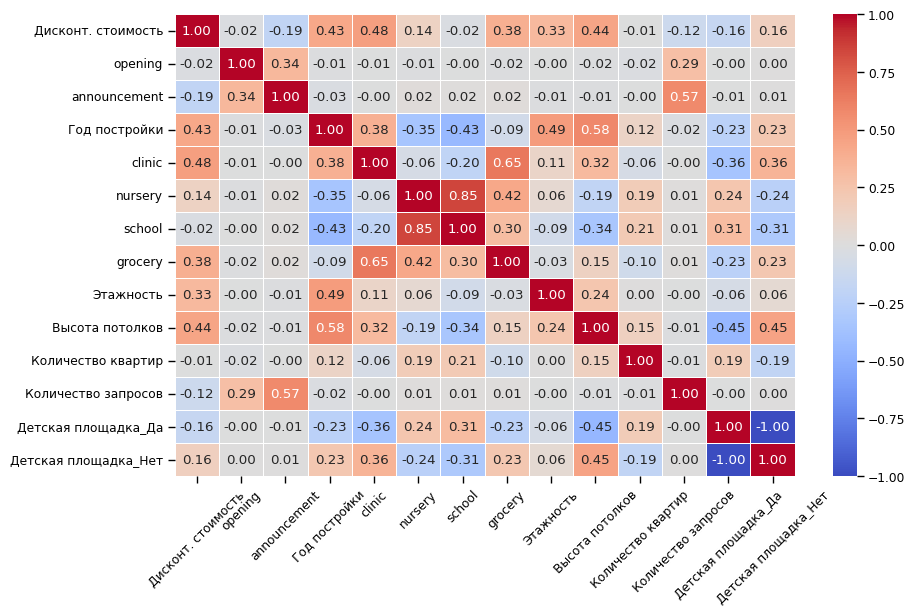

In [558]:
plt.figure(figsize=(10, 6))
sns.set_context("paper")
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
#plt.title("Корреляционная матрица", fontsize = 16)
plt.xticks(rotation=45)
plt.savefig("corr.png", dpi=300, bbox_inches='tight')  

plt.show()

In [36]:
corr_matrix['Дисконт. стоимость'][abs(corr_matrix['Дисконт. стоимость']) > 0.15].sort_values(ascending=False)


Дисконт. стоимость    1.000000
Высота потолков       0.442014
Год постройки         0.430155
Этажность             0.330600
announcement         -0.195145
Name: Дисконт. стоимость, dtype: float64

## Претренд разности-разностей

In [618]:
pretrend_table = matched_data
pretrend_table["treatment"] = (pretrend_table["Сокращение.расстояния"] >= 900).astype(int)

In [ ]:
pretrend_table["log_discounted_value"] = np.log(pretrend_table["discounted_value"])
merged_table_grouped = pretrend_table.groupby(["treatment", "reportDate"])["log_discounted_value"].mean().reset_index()
merged_table_grouped['reportDate'] = pd.to_datetime(merged_table_grouped['reportDate'])
window_size = 1

In [620]:
queries = pretrend_table.groupby("reportDate")["Number.of.queries"].mean().reset_index()
queries['reportDate'] = pd.to_datetime(queries['reportDate'])
merged_table_grouped = merged_table_grouped.merge(queries, on = "reportDate")

ниже сначала график через rolling, потом просто вычитанием средней

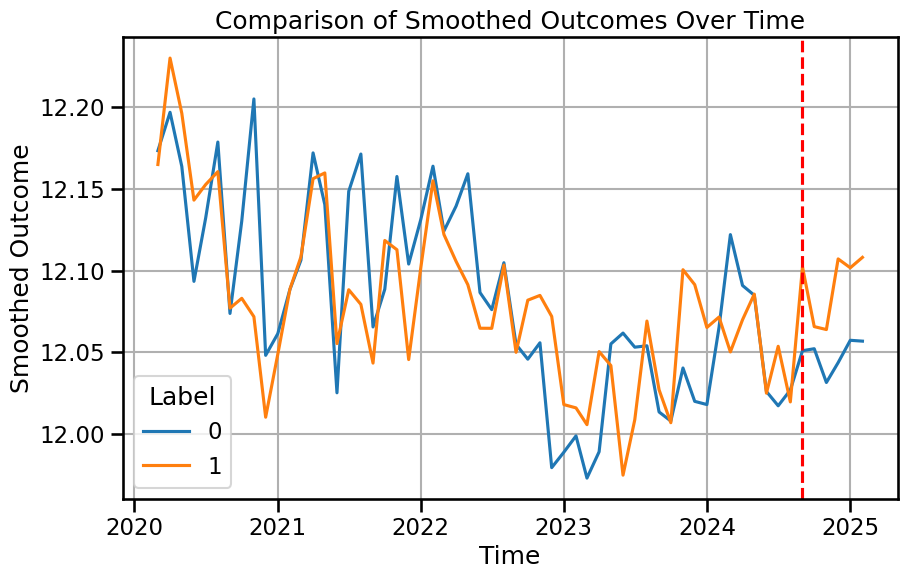

In [608]:
merged_table_grouped['smoothed_log_discounted_value'] = (
    merged_table_grouped.groupby('treatment')['log_discounted_value']
    .transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
)

plt.figure(figsize=(10, 6))

sns.lineplot(data=merged_table_grouped, x='reportDate', y='smoothed_log_discounted_value', hue='treatment')

plt.axvline(x=pd.Timestamp("2024-09-01"), color='red', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Smoothed Outcome')
plt.title('Comparison of Smoothed Outcomes Over Time')
plt.legend(title='Label')
plt.grid(True)
plt.savefig("pretrend", dpi=300)
plt.show()

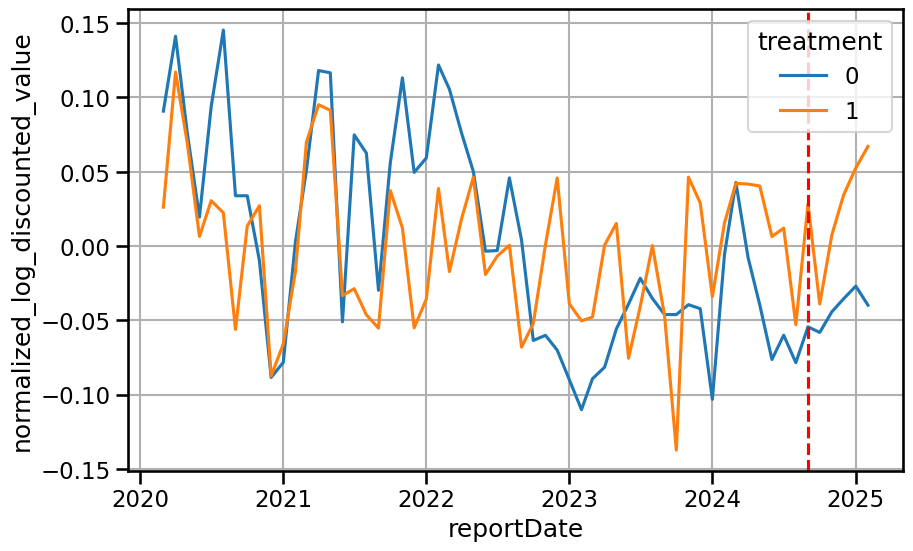

In [621]:
merged_table_grouped['normalized_log_discounted_value'] = (
    merged_table_grouped.groupby('treatment')['log_discounted_value']
    .transform(lambda x: x - x.mean())
)

# merged_table_grouped['smoothed_normalized_value'] = (
#     merged_table_grouped.groupby('treatment')['normalized_log_discounted_value']
#     .transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
# )

plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_table_grouped, x='reportDate', y='normalized_log_discounted_value', hue='treatment')
plt.axvline(x=pd.Timestamp("2024-09-01"), color='red', linestyle='dashed', label='Intervention Date')
plt.grid(True)
plt.savefig("pretrend_normalized.png", dpi=300)
plt.show()


In [ ]:
pretrend_table['post'] = (pretrend_table['reportDate'] > '2024-09-01').astype(int)
pretrend_table['reportDate'] = pd.to_datetime(pretrend_table['reportDate'])

df_pre = pretrend_table[pretrend_table["post"] == 0]

df_pre["time"] = (df_pre["reportDate"] - df_pre["reportDate"].min()).dt.days

model = smf.ols("log_discounted_value ~ time * treatment", data=df_pre).fit()

model.summary()


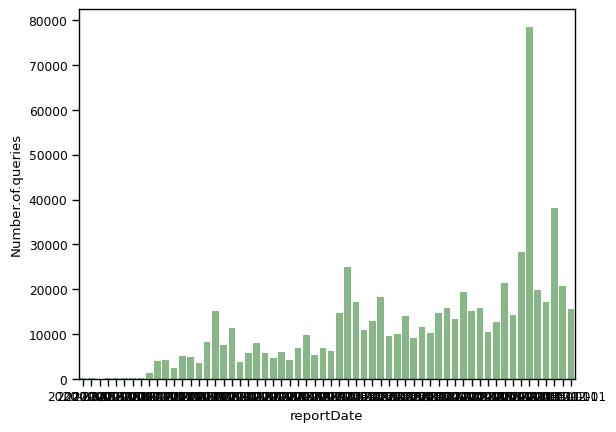

In [132]:
sns.barplot(data=queires_plot, x='reportDate', y='Number.of.queries', color='green', alpha=0.5)
plt.show()

/var/folders/pd/y6gz7fv57txdrm0b2vy7xw040000gn/T/ipykernel_64523/475505827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  queires_plot["reportDate"] = pd.to_datetime(queires_plot["reportDate"])


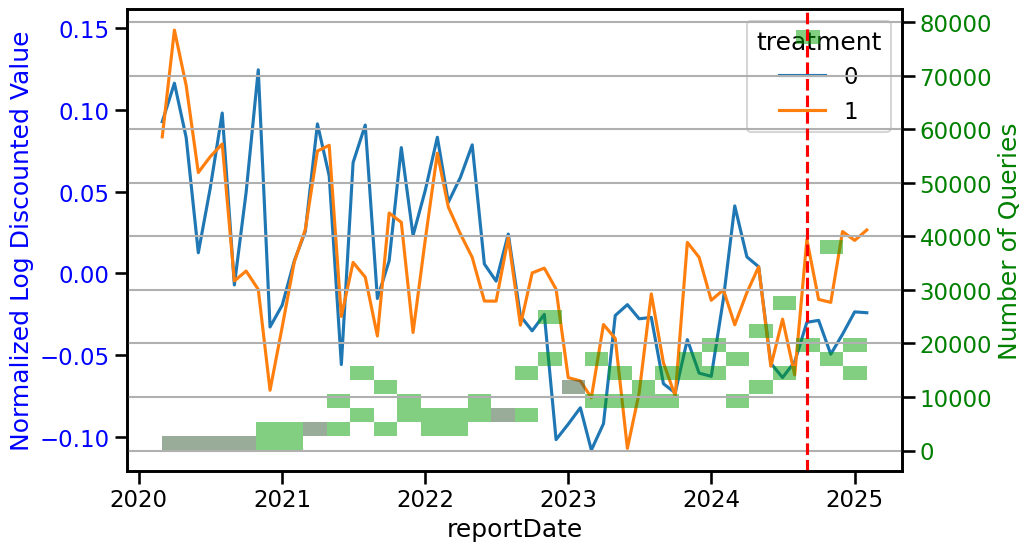

In [607]:
fig, ax1 = plt.subplots(figsize=(10, 6))

queires_plot = merged_table_grouped[merged_table_grouped["treatment"] == 1] # значение в столбце запросов дублируются для одной даты для двух групп 

merged_table_grouped["reportDate"] = pd.to_datetime(merged_table_grouped["reportDate"])
queires_plot["reportDate"] = pd.to_datetime(queires_plot["reportDate"])
queires_plot = queires_plot.sort_values("reportDate")


sns.lineplot(data=merged_table_grouped, x='reportDate', y='normalized_log_discounted_value', hue='treatment', ax=ax1)
ax1.set_ylabel("Normalized Log Discounted Value", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  
sns.histplot(data=queires_plot, x='reportDate', y='Number.of.queries', color='green', ax=ax2, alpha=0.5, bins=30)
ax2.set_ylabel("Number of Queries", color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.axvline(x=pd.Timestamp("2024-09-01"), color='red', linestyle='dashed', label='Intervention Date')
plt.grid(True)

plt.savefig("pretrend_normalized_dual_axis.png", dpi=300)
plt.show()


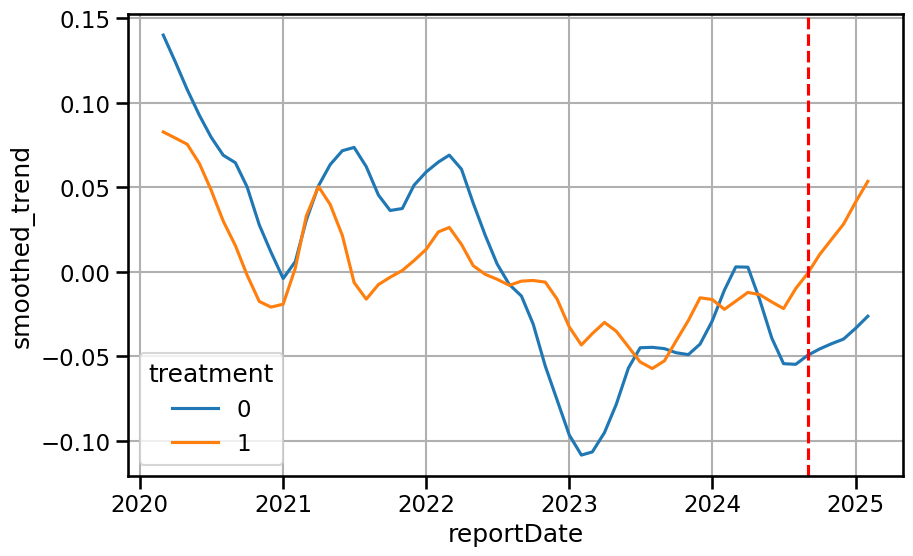

In [617]:
lowess_frac = 0.1  #чем больше, тем плавнее линия
for treatment_group in merged_table_grouped['treatment'].unique():
    subset = merged_table_grouped[merged_table_grouped['treatment'] == treatment_group]
    smoothed_values = sm.nonparametric.lowess(subset['normalized_log_discounted_value'], subset['reportDate'], frac=lowess_frac, return_sorted=False)
    merged_table_grouped.loc[merged_table_grouped['treatment'] == treatment_group, 'smoothed_trend'] = smoothed_values

plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_table_grouped, x='reportDate', y='smoothed_trend', hue='treatment')

plt.axvline(x=pd.Timestamp("2024-09-01"), color='red', linestyle='dashed', label='Intervention Date')
plt.grid(True)
plt.savefig("pretrend_lowess.png", dpi=300)
plt.show()


## Wordstat

In [68]:
queries_2 = pd.read_csv("wordstat_dynamic_feb.csv", sep=";").iloc[:, :2]

In [70]:
queries = pd.read_csv("wordstat_dynamic_feb.csv", sep=";").iloc[:, :2]
queries["Number of queries"] = (
    queries["Number of queries"]
    .astype(str)       # Преобразуем в строку (на всякий случай)
    .str.replace(" ", "")  # Убираем все пробелы
    .astype(float)     # Преобразуем обратно в float
)

queries["Period"] = pd.to_datetime(queries["Period"]).dt.date

queries.rename(columns={"Period":"reportDate"}, inplace=True)

queries

/var/folders/pd/y6gz7fv57txdrm0b2vy7xw040000gn/T/ipykernel_46814/1201439762.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  queries["Period"] = pd.to_datetime(queries["Period"]).dt.date


,reportDate,Number of queries
0,2020-03-01,145.0
1,2020-04-01,104.0
2,2020-05-01,89.0
3,2020-06-01,140.0
4,2020-07-01,285.0
5,2020-08-01,231.0
6,2020-09-01,165.0
7,2020-10-01,171.0
8,2020-11-01,1252.0
9,2020-12-01,3965.0


In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(queries["Period"], queries["Number of queries"])
# plt.show()

In [89]:
merged_table["reportDate"] = pd.to_datetime(merged_table["reportDate"])
queries["reportDate"] = pd.to_datetime(queries["reportDate"])

merged_table = merged_table.merge(queries[["reportDate", "Number of queries"]], on ="reportDate", how="left")
merged_table.reportDate = merged_table.reportDate.dt.date

In [95]:
merged_table.rename(columns = {"Number of queries_y" : "Number of queries"}, inplace = True)

In [98]:
merged_table.shape

(4395, 37)

In [92]:
merged_table.drop(columns = ["Number of queries_x"], inplace = True)
merged_table.rename(columns = {"Number of queries_x" : "Number of queries"})

,value,reportDate,prettyValue,realty_id,Адрес,URL,Год постройки,Тип дома,Этажность,Строительная серия,...,Название второй станции,Название третьей станции,Ближайшая станция после тритмента расстояние,Ближайшая станция после тритмента,Ближайшая станция до тритмента расстояние,Ближайшая станция до тритмента,Сокращение расстояния,cumprod,discounted_value,Number of queries_y
0,220493.0,2020-03-01,220 493 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,1.0000,220493.000000,145.0
1,228764.0,2020-04-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,1.0000,228764.000000,104.0
2,228764.0,2020-05-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,1.0000,228764.000000,89.0
3,239315.0,2020-06-01,239 315 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,1.0508,227745.527217,140.0
4,236383.0,2020-07-01,236 383 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0,1.0508,224955.272174,285.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4390,333333.0,2024-06-01,333 333 ₽/м²,99,"Москва, улица Академика Арцимовича, 2К2",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Панельный,9,1605-АМ,...,Беляево,Коньково,663.0,Университет Дружбы Народов,1050.0,Беляево,387.0,1.7547,189965.806121,21350.0
4391,333333.0,2024-07-01,333 333 ₽/м²,99,"Москва, улица Академика Арцимовича, 2К2",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Панельный,9,1605-АМ,...,Беляево,Коньково,663.0,Университет Дружбы Народов,1050.0,Беляево,387.0,1.7547,189965.806121,14210.0
4392,322222.0,2024-08-01,322 222 ₽/м²,99,"Москва, улица Академика Арцимовича, 2К2",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Панельный,9,1605-АМ,...,Беляево,Коньково,663.0,Университет Дружбы Народов,1050.0,Беляево,387.0,1.7547,183633.669573,28204.0
4393,322222.0,2024-09-01,322 222 ₽/м²,99,"Москва, улица Академика Арцимовича, 2К2",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Панельный,9,1605-АМ,...,Беляево,Коньково,663.0,Университет Дружбы Народов,1050.0,Беляево,387.0,1.6769,192153.378257,78510.0


In [517]:
merged_table.to_csv("merged_table.csv", index=False)

## Индекс цен недвижимости

In [133]:
df = pd.read_csv("real_estate_index2.csv", sep=";")
df = df.iloc[:, :4]

In [142]:
df.head()

,reportDate,Quarter,index,cumprod
0,2020-03-01,I квартал,"100,","1,"
1,2020-06-01,II квартал,"105,08","1,0508"
2,2020-09-01,III квартал,"110,22","1,1582"
3,2020-12-01,IV квартал,"108,54","1,2571"
4,2021-03-01,I квартал,"100,37","1,2618"


In [134]:
df["cumprod"] = df["cumprod"].astype(str).str.replace(",", ".").astype(float)
df["index"] = df["index"].astype(str).str.replace(",", ".").astype(float)

df["index"] = df["index"].astype(float)/100
# df["reportDate"] = pd.to_datetime(df["reportDate"]).dt.strftime('%Y-%m-%d')
# df["reportDate"] = pd.to_datetime(df["reportDate"], format="%Y-%d-%m").dt.strftime("%Y-%m-%d")

In [144]:
merged_table["reportDate"] = pd.to_datetime(merged_table["reportDate"])
df["reportDate"] = pd.to_datetime(df["reportDate"])

merged_table = merged_table.merge(df[["reportDate", "cumprod"]], on ="reportDate", how="left")
merged_table.reportDate = merged_table.reportDate.dt.strftime('%Y-%m-%d')

In [145]:
merged_table["cumprod"] = merged_table["cumprod"].ffill().bfill()

In [146]:
merged_table["discounted_value"] = merged_table["value"] / merged_table["cumprod"]

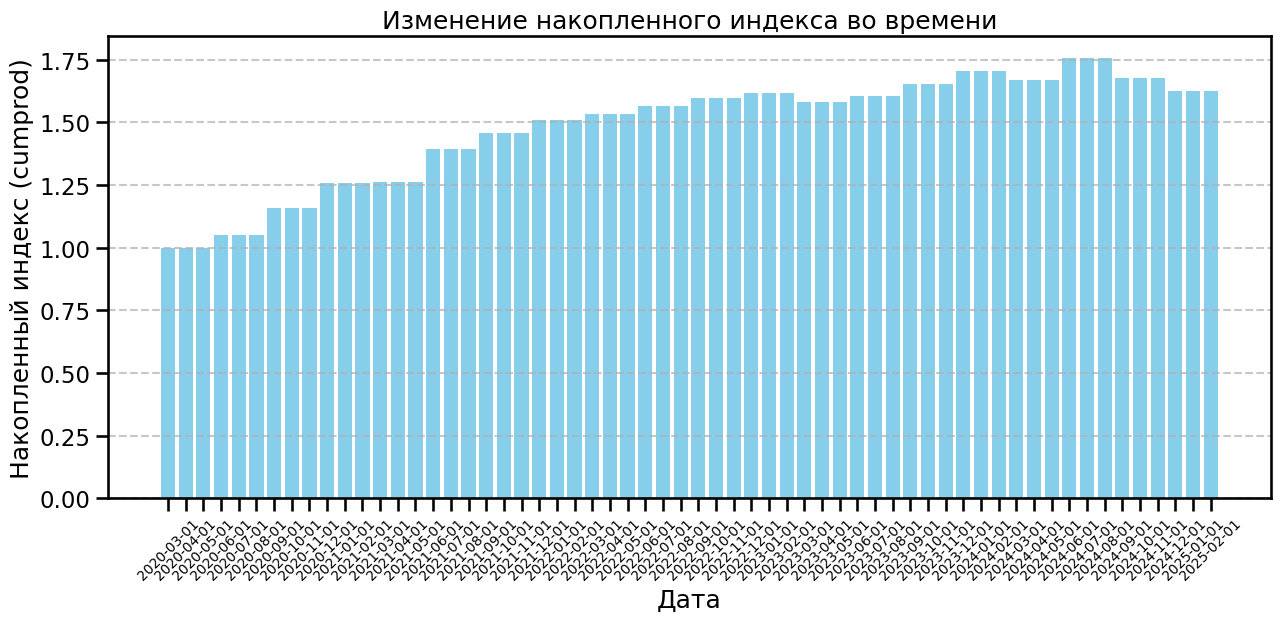

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6)) 

plt.bar(merged_table["reportDate"], merged_table["cumprod_y"], color="skyblue")


plt.xticks(rotation=45, fontsize=10) 
plt.xlabel("Дата")
plt.ylabel("Накопленный индекс (cumprod)")
plt.title("Изменение накопленного индекса во времени")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("index", dpi=300)
plt.show()


## Парсинг

1 - 45 Университет Дружбы народов

46 - 69 Генерала Тюленева

70 - 91 Генерала Тюленева + Тютчевская

92 - Потапово

In [343]:
urls_prices = [
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1697035&roomsCount=all&period=all", 
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=34441&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56706&roomsCount=all&period=all",        
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18008&roomsCount=all&period=all",                
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56710&roomsCount=all&period=all",        
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71098&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=47492&roomsCount=all&period=all",     
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=989953&roomsCount=all&period=all",    
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71097&roomsCount=all&period=all",  
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71099&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=3245139&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18007&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58805&roomsCount=all&period=all",                  
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1080888&roomsCount=all&period=all",            
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56705&roomsCount=all&period=all", 
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=47490&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18000&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17997&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=606455&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1701671&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17998&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=32592&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58801&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1711316&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58806&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58795&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1695695&roomsCount=all&period=all",    
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18013&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79556&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79557&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1713733&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1715736&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1704699&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79567&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79561&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79525&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79570&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79569&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79572&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79539&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1703841&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1696643&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17957&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1715434&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17956&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1724532&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1703284&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1695949&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1700137&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1781723&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=606384&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17945&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1691421&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41145&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1702798&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1713741&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1695987&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41147&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79549&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79540&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79533&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79548&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79547&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79545&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41159&roomsCount=all&period=all",
    #"https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1847202&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1803888&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1833802&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1873062&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1807554&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1864728&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1813861&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1096058&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1769520&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1870385&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18009&roomsCount=all&period=all",
    #"https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=32599&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=17996&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=58813&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1707726&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56654&roomsCount=all&period=all",
    #"https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=972356&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1850461&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1848324&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1846881&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1869028&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1873180&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1893398&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1831914&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41162&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79514&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79515&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1768971&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=41157&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79562&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1803178&roomsCount=all&period=all",
    #"https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79567&roomsCount=oneRoom&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=79528&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1697086&roomsCount=all&period=all",
    "https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=32593&roomsCount=all&period=all",

    
    ]

In [378]:
urls_house_info = [
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+6&totalArea=38.4&roomsCount=1&offerId=309089270&floor=floorOther&repairType=repairTypeDesign",                                                                                   
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C+2%D0%9A1&totalArea=60.0&roomsCount=3&offerId=311850058&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A3&totalArea=52.5&roomsCount=3&offerId=307635407&floor=floorOther&repairType=repairTypeWithout",                                                                                                       
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+25%D0%9A1&totalArea=33.0&roomsCount=1&offerId=307458577&floor=floorOther&repairType=repairTypeWithout",                                                              
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A7&totalArea=75.9&roomsCount=3&offerId=310793059&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A3&totalArea=81.1&roomsCount=3&offerId=309936581&floor=floorOne&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F+%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C+27%D0%9A1&totalArea=73.8&roomsCount=3&offerId=308129789&floor=floorOther&repairType=repairTypeWithout",                                               
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+8%D0%BA3&totalArea=58.0&roomsCount=2&offerId=309527570&floor=floorOther&repairType=repairTypeWithout",                                                                         
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A2&totalArea=79.5&roomsCount=3&offerId=309254865&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+4%D0%9A4&totalArea=55.2&roomsCount=2&offerId=308290049&floor=floorLast&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+2%D0%90&totalArea=120.0&roomsCount=3&offerId=309980787&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+23%D0%9A1&totalArea=60.0&roomsCount=3&offerId=306765780&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9%D0%9A4&totalArea=39.0&roomsCount=1&offerId=307912564&floor=floorLast&repairType=repairTypeEuro",                                                     
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%BA6&totalArea=41.0&roomsCount=1&offerId=311945204&floor=floorOther&repairType=repairTypeEuro",                                                                                     
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A2&totalArea=71.6&roomsCount=4&offerId=311912659&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F+%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C+25&totalArea=38.7&roomsCount=1&offerId=310270512&floor=floorLast&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+15%D0%9A3&totalArea=66.4&roomsCount=3&offerId=311328806&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+15%D0%9A1&totalArea=63.0&roomsCount=3&offerId=300302109&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+8%D0%90&totalArea=95.1&roomsCount=3&offerId=311908456&floor=floorTwo&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+13&totalArea=45.3&roomsCount=2&offerId=307780981&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+15%D0%9A2&totalArea=45.0&roomsCount=2&offerId=299209036&floor=floorTwo&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+2%D0%9A1&totalArea=40.0&roomsCount=1&offerId=309589901&floor=floorTwo&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9%D0%9A1&totalArea=52.5&roomsCount=1&offerId=308770205&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+8&totalArea=45.8&roomsCount=2&offerId=311262176&floor=floorLast&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9%D0%9A5&totalArea=120.0&roomsCount=3&offerId=303870632&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+5%D0%9A3&totalArea=51.0&roomsCount=1&offerId=311125656&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+9&totalArea=66.6&roomsCount=2&offerId=311234104&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+31%D0%9A2&totalArea=64.0&roomsCount=3&offerId=310639393&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A1&totalArea=75.0&roomsCount=3&offerId=303230896&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A2&totalArea=26.0&roomsCount=1&offerId=308076419&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+4&totalArea=50.6&roomsCount=2&offerId=310662654&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+8&totalArea=59.0&roomsCount=3&offerId=310505447&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+23&totalArea=36.8&roomsCount=1&offerId=311772311&floor=floorLast&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A1&totalArea=37.6&roomsCount=1&offerId=310947195&floor=floorLast&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A5&totalArea=45.2&roomsCount=2&offerId=312120809&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+12%D0%9A1&totalArea=38.5&roomsCount=2&offerId=310625201&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A5&totalArea=45.0&roomsCount=2&offerId=308637655&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A4&totalArea=62.0&roomsCount=3&offerId=288824068&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+27&totalArea=54.0&roomsCount=2&offerId=311120890&floor=floorLast&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+14%2F2&totalArea=44.4&roomsCount=2&offerId=301200222&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+5&totalArea=76.2&roomsCount=4&offerId=308144018&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+3&totalArea=60.8&roomsCount=3&offerId=302971287&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+4%D0%9A2&totalArea=40.0&roomsCount=2&offerId=310967629&floor=floorOther",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+6&totalArea=60.0&roomsCount=3&offerId=308397152&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+4%D0%9A1&totalArea=34.1&roomsCount=1&offerId=305930485&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+12&totalArea=50.8&roomsCount=2&offerId=304858455&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C+1&totalArea=102.2&roomsCount=3&offerId=311371966&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+6&totalArea=45.2&roomsCount=2&offerId=308908363&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+2&totalArea=32.5&roomsCount=1&offerId=312295732&floor=floorOne&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+8&totalArea=65.6&roomsCount=3&offerId=312454781&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+28&totalArea=32.6&roomsCount=1&offerId=307775309&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+36&totalArea=73.4&roomsCount=3&offerId=311208660&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+11&totalArea=64.0&roomsCount=3&offerId=310743428&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+7%D0%9A1&totalArea=61.0&roomsCount=3&offerId=311126074&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+13&totalArea=68.0&roomsCount=3&offerId=304856437&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+15&totalArea=51.3&roomsCount=2&offerId=311160192&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+17&totalArea=51.0&roomsCount=2&offerId=302404390&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+7%D0%9A2&totalArea=34.7&roomsCount=1&offerId=308231609&floor=floorTwo&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A7&totalArea=52.0&roomsCount=2&offerId=309113077&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A1&totalArea=63.5&roomsCount=2&offerId=301855337&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+13%D0%9A1&totalArea=58.8&roomsCount=2&offerId=308746096&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A6&totalArea=51.5&roomsCount=2&offerId=309117903&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A5&totalArea=61.5&roomsCount=3&offerId=294319016&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+15%D0%9A4&totalArea=34.8&roomsCount=1&offerId=312464277&floor=floorOne&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+25&totalArea=51.5&roomsCount=2&offerId=309890288&floor=floorOther&repairType=repairTypeCosmetic",
    #"https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+1&totalArea=67.4&roomsCount=2&offerId=309636118&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+18&totalArea=50.5&roomsCount=1&offerId=310314749&floor=floorTwo&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+35&totalArea=54.0&roomsCount=1&offerId=312231467&floor=floorTwo&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+31&totalArea=44.9&roomsCount=2&offerId=308567781&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+33&totalArea=51.4&roomsCount=2&offerId=303243667&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+28&totalArea=33.3&roomsCount=1&offerId=307890576&floor=floorTwo&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+29&totalArea=33.9&roomsCount=1&offerId=311586464&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%9E%D0%BF%D0%B0%D1%80%D0%B8%D0%BD%D0%B0%2C+4%D0%BA1&totalArea=54.0&roomsCount=1&offerId=313034357&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+19&totalArea=65.0&roomsCount=3&offerId=312577524&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+17&totalArea=36.0&roomsCount=1&offerId=313352960&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+25%D0%9A2&totalArea=64.0&roomsCount=3&offerId=313715861&floor=floorOther&repairType=repairTypeCosmetic",
    #"https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+5%D0%9A1&totalArea=41.8&roomsCount=2&offerId=313486539&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+14%D0%9A3&totalArea=75.6&roomsCount=3&offerId=307390635&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C+11%D0%9A1&totalArea=120.0&roomsCount=4&offerId=303619557&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+18&totalArea=70.3&roomsCount=4&offerId=312890563&floor=floorOther",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+4%D0%9A1&totalArea=44.6&roomsCount=2&offerId=303885699&floor=floorOther&repairType=repairTypeCosmetic",
    #"https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9+%D0%BF%D1%80%D0%BE%D1%81%D0%BF%D0%B5%D0%BA%D1%82%2C+111%D0%BA1&totalArea=161.1&roomsCount=3&offerId=302152670&floor=floorOther&repairType=repairTypeDesign",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+17&totalArea=67.3&roomsCount=3&offerId=312621729&floor=floorOther&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+7&totalArea=47.1&roomsCount=2&offerId=313145420&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D1%80%D0%BE%D1%8F+%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8+%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C+5&totalArea=60.0&roomsCount=3&offerId=312946294&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+%D0%BF%D1%80%D0%BE%D0%B5%D0%B7%D0%B4+%D0%9C%D1%83%D0%B7%D1%8B%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%2C+2&totalArea=63.0&roomsCount=3&offerId=309757665&floor=floorOne&repairType=repairTypeEuro",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+24&totalArea=64.1&roomsCount=3&offerId=313274507&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+16&totalArea=33.2&roomsCount=1&offerId=302189887&floor=floorOne&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D0%BF%D0%BE%D1%81.+%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0+%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C+15&totalArea=60.3&roomsCount=3&offerId=309818928&floor=floorLast&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+27&totalArea=52.1&roomsCount=2&offerId=302329954&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+9%D0%9A6&totalArea=60.1&roomsCount=3&offerId=312759234&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+9%D0%9A7&totalArea=55.0&roomsCount=2&offerId=309582779&floor=floorTwo&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+3&totalArea=51.0&roomsCount=2&offerId=313645435&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0+%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C+23%D0%9A1&totalArea=34.9&roomsCount=1&offerId=313640883&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+21%D0%9A6&totalArea=35.8&roomsCount=1&offerId=312986899&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+6&totalArea=44.2&roomsCount=2&offerId=313426885&floor=floorOther&repairType=repairTypeCosmetic",
    #"https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+25%D0%9A1&totalArea=37.5&roomsCount=1&offerId=313504727&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9+%D0%A1%D1%82%D0%B0%D0%BD%2C+12%D0%9A4&totalArea=49.8&roomsCount=3&offerId=313168066&floor=floorOther&repairType=repairTypeCosmetic",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C+18&totalArea=52.0&roomsCount=2&offerId=313728416&floor=floorOther&repairType=repairTypeWithout",
    "https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C+2%D0%9A2&totalArea=43.0&roomsCount=2&offerId=313737828&floor=floorOther&repairType=repairTypeCosmetic",
    
    
]   

In [344]:
urls_metro = [
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%206",                                                            
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C%202%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A3",                                                                                   
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2025%D0%9A1",                                        
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A7",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C%2027%D0%9A1",                              
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%208%D0%BA3",                                                             
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%204%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%202%D0%90",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2023%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209%D0%9A4",                      
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%BA6",                                                                            
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9C%D0%B8%D0%BA%D0%BB%D1%83%D1%85%D0%BE-%D0%9C%D0%B0%D0%BA%D0%BB%D0%B0%D1%8F%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%2C%2025",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2015%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2015%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%208%D0%90",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2013",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2015%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%202%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%208",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%205%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%209",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2031%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%204",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%208",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2023",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2012%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2027",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2014%2F2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%205",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%203",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%204%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%206",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%204%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%2012",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B8%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4%D0%BE%D0%B2%D0%B0%2C%201",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%206",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%202",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%208",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%2028",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%2036",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2011",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%207%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2013",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2015",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2017",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%207%D0%9A2",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A7",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2013%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A6",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A5",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2015%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2025",
    #"https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%201",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%2018",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2035",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2031",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2033",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2028",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2029",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%9E%D0%BF%D0%B0%D1%80%D0%B8%D0%BD%D0%B0%2C%204%D0%BA1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2019",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2017",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2025%D0%9A2",
    #"https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%205%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C%2014%D0%9A3",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D1%81%D1%82%D1%80%D0%BE%D0%B2%D0%B8%D1%82%D1%8F%D0%BD%D0%BE%D0%B2%D0%B0%2C%2011%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2018",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%204%D0%9A1",
    #"https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%9B%D0%B5%D0%BD%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9%20%D0%BF%D1%80%D0%BE%D1%81%D0%BF%D0%B5%D0%BA%D1%82%2C%20111%D0%BA1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%2017",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%207",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D1%80%D0%BE%D1%8F%20%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8%20%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D0%BD%D0%B0%2C%205",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%20%D0%BF%D1%80%D0%BE%D0%B5%D0%B7%D0%B4%20%D0%9C%D1%83%D0%B7%D1%8B%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%2C%202",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2024",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2016",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2015",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2027",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%209%D0%9A6",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%209%D0%9A7",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%203",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D0%B0%20%D0%A2%D1%8E%D0%BB%D0%B5%D0%BD%D0%B5%D0%B2%D0%B0%2C%2023%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2021%D0%9A6",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%206",
    #"https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2025%D0%9A1",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%2012%D0%9A4",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%2018",
    "https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%90%D1%80%D1%86%D0%B8%D0%BC%D0%BE%D0%B2%D0%B8%D1%87%D0%B0%2C%202%D0%9A2",

]

In [ ]:
repeated_indices = {}

for idx, value in enumerate(urls_prices):
    if urls_prices.count(value) > 1:
        repeated_indices.setdefault(value, []).append(idx)

print(repeated_indices)  # {1: [0, 7, 9], 2: [1, 4], 3: [2, 5]}


{}


### Парсим цены

In [172]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

all_data = []

def fetch_and_process_url(url, realty_id):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            data = response.json()  
            if 'houseTrand' in data:
                trend_data = pd.DataFrame(data['houseTrand'])
                trend_data['value'] = trend_data['value'].astype(float)
                trend_data['reportDate'] = pd.to_datetime(trend_data['reportDate'])
                trend_data['realty_id'] = realty_id 
                return trend_data
            else:
                print(f"Ключ 'houseTrand' отсутствует в ответе для {url}")
        else:
            print(f"Ошибка {response.status_code} при запросе {url}")
    except requests.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
    return None

for idx, url in enumerate(urls_prices, start=1):
    print(f"Обработка ссылки {idx}/{len(urls_prices)}: {url}")
    trend_data = fetch_and_process_url(url, realty_id=idx)
    if trend_data is not None:
        all_data.append(trend_data)
    
    pause = random.uniform(30, 33)
    print(f"Пауза {pause:.2f} секунд...")
    time.sleep(pause)

if all_data:
    prices_data = pd.concat(all_data, ignore_index=True)
    prices_data

Обработка ссылки 1/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=1697035&roomsCount=all&period=all
Пауза 30.25 секунд...
Обработка ссылки 2/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=34441&roomsCount=all&period=all
Пауза 30.63 секунд...
Обработка ссылки 3/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56706&roomsCount=all&period=all
Пауза 30.16 секунд...
Обработка ссылки 4/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=18008&roomsCount=all&period=all
Пауза 33.00 секунд...
Обработка ссылки 5/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=56710&roomsCount=all&period=all
Пауза 31.31 секунд...
Обработка ссылки 6/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?realtyId=71098&roomsCount=all&period=all
Пауза 31.66 секунд...
Обработка ссылки 7/99: https://api.cian.ru/valuation-offer-history/v1/get-market-trand/?real

In [173]:
prices_data.shape

(4497, 4)

In [120]:
prices_data

,value,reportDate,prettyValue,realty_id
0,220493.0,2020-03-01,220 493 ₽/м²,1
1,228764.0,2020-04-01,228 764 ₽/м²,1
2,228764.0,2020-05-01,228 764 ₽/м²,1
3,239315.0,2020-06-01,239 315 ₽/м²,1
4,236383.0,2020-07-01,236 383 ₽/м²,1
...,...,...,...,...
4523,333333.0,2024-06-01,333 333 ₽/м²,100
4524,333333.0,2024-07-01,333 333 ₽/м²,100
4525,322222.0,2024-08-01,322 222 ₽/м²,100
4526,322222.0,2024-09-01,322 222 ₽/м²,100


In [175]:
prices_data.to_csv("prices_data.csv", index=False)

### Парсим характеристики дома

In [174]:
columns = [
    "realty_id", "Адрес", "Год постройки", "Тип дома", "Этажность", "Строительная серия", "Высота потолков",
    "Газоснабжение", "Отопление", "Тип перекрытий", "Подъездов", "Количество лифтов",
    "Мусоропроводов", "Квартир", "Реновация", "Аварийность", "Детская площадка",
    "Спортивная площадка", "Фонд капитального ремонта", "URL"
]
data_house_features = pd.DataFrame(columns=columns)


def parse_page(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            print(f"Ошибка загрузки страницы: {response.status_code} для {url}")
            return None

        soup = BeautifulSoup(response.text, "html.parser")


        address_block = soup.find("span", class_="f0b5faa8cb--color_gray60_100--mYFjS")
        address = address_block.text.strip() if address_block else "Адрес не найден"

        name_blocks = soup.find_all("div", class_="f0b5faa8cb--name--vfsqB")
        value_blocks = soup.find_all("div", class_="f0b5faa8cb--val--YiBYQ")

        if len(name_blocks) == len(value_blocks):
            data = {"Адрес": address, "URL": url}  
            for name, value in zip(name_blocks, value_blocks):
                key = name.text.strip()
                val = value.text.strip()
                data[key] = val
            return data
        else:
            print(f"Количество названий и значений не совпадает для {url}.")
            return None
    except requests.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
        return None


parsed_data_list = []
for idx, url in enumerate(urls_house_info, start=1): 
    print(f"Обработка {idx}/{len(urls_house_info)}: {url}")
    parsed_data = parse_page(url)
    if parsed_data:
        parsed_data["realty_id"] = idx  
        
        for col in columns:
            if col not in parsed_data:
                parsed_data[col] = None
        parsed_data_list.append(parsed_data)
    
   
    pause = random.uniform(30, 33)
    print(f"Пауза {pause:.2f} секунд...")
    time.sleep(pause)


if parsed_data_list:
    data_house_features = pd.concat([pd.DataFrame([data]) for data in parsed_data_list], ignore_index=True)
    print("Данные успешно собраны.")
else:
    print("Нет данных для объединения.")

Обработка 1/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B+%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C+6&totalArea=38.4&roomsCount=1&offerId=309089270&floor=floorOther&repairType=repairTypeDesign
Пауза 31.45 секунд...
Обработка 2/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C+2%D0%9A1&totalArea=60.0&roomsCount=3&offerId=311850058&floor=floorOther&repairType=repairTypeDesign
Пауза 32.74 секунд...


Обработка 3/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A3&totalArea=52.5&roomsCount=3&offerId=307635407&floor=floorOther&repairType=repairTypeWithout
Пауза 32.22 секунд...
Обработка 4/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0+%D0%92%D0%BE%D0%BB%D0%B3%D0%B8%D0%BD%D0%B0%2C+25%D0%9A1&totalArea=33.0&roomsCount=1&offerId=307458577&floor=floorOther&repairType=repairTypeWithout
Пауза 30.37 секунд...
Обработка 5/99: https://www.cian.ru/kalkulator-nedvizhimosti/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C+%D1%83%D0%BB%D0%B8%D1%86%D0%B0+%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C+28%D0%9A7&totalArea=75.9&roomsCount=3&offerId=310793059&floor=floorOther&repairType=repairTypeCosmetic
Пауза 32.10 секунд...

In [176]:
data_house_features.shape

(99, 20)

In [177]:
data_house_features.to_csv("house_features.csv", index=False)

### Парсим расстояние до метро

In [116]:

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

all_metro_data = []


def fetch_and_process_metro(url, realty_id):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            data = response.json()  
            if 'metro' in data:  
                metro_list = data['metro']
                metro_data = []
                for metro in metro_list:
                    metro_data.append({
                        "Станция": metro["name"],
                        "Расстояние (м)": metro["distance"],
                        "Тип транспорта": "Пешком" if metro["travelType"] == "byFoot" else "На машине",
                        "Время в пути (мин)": metro["travelTime"],
                        "realty_id": realty_id
                    })
                return pd.DataFrame(metro_data)
            else:
                print(f"Ключ 'metro' отсутствует в ответе для {url}")
        else:
            print(f"Ошибка {response.status_code} при запросе {url}")
    except requests.RequestException as e:
        print(f"Ошибка при запросе {url}: {e}")
    return None

for idx, url in enumerate(urls_metro, start=1):
    print(f"Обработка ссылки {idx}/{len(urls_metro)}: {url}")
    metro_data = fetch_and_process_metro(url, realty_id=idx)
    if metro_data is not None:
        all_metro_data.append(metro_data)
    
    
    pause = random.uniform(30, 35)
    print(f"Пауза {pause:.2f} секунд...")
    time.sleep(pause)


if all_metro_data:
    metro_data = pd.concat(all_metro_data, ignore_index=True)
    print("Данные о метро успешно собраны.")
else:
    metro_data = pd.DataFrame()  
    print("Нет данных для объединения.")

print(metro_data)


NameError: name 'urls_metro' is not defined

In [180]:
metro_data.to_csv("metro_data.csv", index=False)

In [112]:
metro_data.shape

(297, 5)

In [ ]:
nearest_stations = (
    metro_data.sort_values(by=["realty_id", "Расстояние (м)"])
    .groupby("realty_id")
    .head(3) 
    .reset_index(drop=True)
)

result = nearest_stations.pivot_table(
    index="realty_id",
    values=["Расстояние (м)", "Станция"],
    aggfunc=lambda x: list(x)[:3]  
).reset_index()

# Разделяем расстояния и названия станций по столбцам
result[["Расстояние до первой станции", "Расстояние до второй станции", "Расстояние до третьей станции"]] = pd.DataFrame(result["Расстояние (м)"].tolist(), index=result.index)
result[["Название первой станции", "Название второй станции", "Название третьей станции"]] = pd.DataFrame(result["Станция"].tolist(), index=result.index)

result = result.drop(columns=["Расстояние (м)", "Станция"])

excluded_stations = ["Университет Дружбы Народов", "Тютчевская", "Генерала Тюленева", "Корниловская", "Потапово"]

# Находим ближайшую станцию для каждого объекта
nearest_station = (
    metro_data.sort_values(by=["realty_id", "Расстояние (м)"])
    .groupby("realty_id")
    .first()
    .reset_index()
    .rename(columns={"Расстояние (м)": "Ближайшая станция после тритмента расстояние", "Станция": "Ближайшая станция после тритмента"})
)

# Находим ближайшую станцию, которая не входит в исключения
filtered_stations = (
    metro_data[~metro_data["Станция"].isin(excluded_stations)]
    .sort_values(by=["realty_id", "Расстояние (м)"])
    .groupby("realty_id")
    .first()
    .reset_index()
    .rename(columns={"Расстояние (м)": "Ближайшая станция до тритмента расстояние", 
                     "Станция": "Ближайшая станция до тритмента"})
)

result = result.merge(nearest_station[["realty_id", "Ближайшая станция после тритмента расстояние", "Ближайшая станция после тритмента"]], on="realty_id", how="left")
result = result.merge(filtered_stations[["realty_id", "Ближайшая станция до тритмента расстояние", "Ближайшая станция до тритмента"]], on="realty_id", how="left")

result["Сокращение расстояния"] = (
    result["Ближайшая станция до тритмента расстояние"] - result["Ближайшая станция после тритмента расстояние"]
)

result.head()


,realty_id,Расстояние до первой станции,Расстояние до второй станции,Расстояние до третьей станции,Название первой станции,Название второй станции,Название третьей станции,Ближайшая станция после тритмента расстояние,Ближайшая станция после тритмента,Ближайшая станция до тритмента расстояние,Ближайшая станция до тритмента,Сокращение расстояния
0,1,881.0,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
1,2,1297.0,1311.0,1483.0,Университет Дружбы Народов,Калужская,Воронцовская,1297.0,Университет Дружбы Народов,1311.0,Калужская,14.0
2,3,978.0,1816.0,2680.0,Университет Дружбы Народов,Воронцовская,Новаторская,978.0,Университет Дружбы Народов,1816.0,Воронцовская,838.0
3,4,930.0,1169.0,1450.0,Университет Дружбы Народов,Беляево,Коньково,930.0,Университет Дружбы Народов,1169.0,Беляево,239.0
4,5,1060.0,1542.0,1752.0,Университет Дружбы Народов,Калужская,Воронцовская,1060.0,Университет Дружбы Народов,1542.0,Калужская,482.0


In [118]:
result.shape

(99, 12)

In [ ]:
#merged_table = prices_data.merge(data_house_features, on='realty_id', how='left').merge(result, on='realty_id', how='left')
#merged_table.to_csv("merged_table.csv", index=False)

In [132]:
merged_table["Ближайшая станция после тритмента"].value_counts()

Ближайшая станция после тритмента
Генерала Тюленева             2204
Университет Дружбы Народов    1756
Тютчевская                     392
Корниловская                    43
Name: count, dtype: int64

In [134]:
merged_table.head()

,value,reportDate,prettyValue,realty_id,Адрес,URL,Год постройки,Тип дома,Этажность,Строительная серия,...,Расстояние до второй станции,Расстояние до третьей станции,Название первой станции,Название второй станции,Название третьей станции,Ближайшая станция после тритмента расстояние,Ближайшая станция после тритмента,Ближайшая станция до тритмента расстояние,Ближайшая станция до тритмента,Сокращение расстояния
0,220493.0,2020-03-01,220 493 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
1,228764.0,2020-04-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
2,228764.0,2020-05-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
3,239315.0,2020-06-01,239 315 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0
4,236383.0,2020-07-01,236 383 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,2370.0,2957.0,Университет Дружбы Народов,Беляево,Тропарёво,881.0,Университет Дружбы Народов,2370.0,Беляево,1489.0


### Парсинг инфрастурктуры района

In [401]:
import requests
import json
import pandas as pd
import time

def parse_distance(distance_str):
    """
    Преобразует строку расстояния в метры.
    Например:
      "442 м"  -> 442
      "1.2 км" -> 1200
    """
    distance_str = distance_str.strip()
    if "км" in distance_str:
        value = float(distance_str.replace("км", "").strip().replace(",", "."))
        return value * 1000
    elif "м" in distance_str:
        return float(distance_str.replace("м", "").strip().replace(",", "."))
    else:
        return float(distance_str)

def parse_page(url):
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            print(f"Ошибка загрузки страницы: {response.status_code} для {url}")
            return None
        return response.json()
    except Exception as e:
        print(f"Ошибка при запросе к {url}: {e}")
        return None

def get_multiple_infrastructure_counts(api_url_list, radius_m=1500):
    """
    Получает данные об инфраструктуре (магазины, клиники, детские сады, школы)
    для списка полных API‑запросов и подсчитывает объекты, находящиеся в пределах заданного радиуса (в метрах).

    Параметры:
      - api_url_list (list): список полных URL‑ов для запроса
      - radius_m (int): радиус поиска объектов в метрах

    Возвращает:
      - DataFrame с id, api_url и количеством объектов по категориям.
    """
    results = []
    
    for idx, api_url in enumerate(api_url_list, start=1):
        print(f"Обработка {idx}/{len(urls_house_info)}: {api_url}")
        data = parse_page(api_url)
        
        if data is not None:
            # Инициализируем счетчики для нужных категорий
            categories = {"grocery": 0, "clinic": 0, "nursery": 0, "school": 0}
            
            for infra in data["infrastructure"]["infrastructure"]:
                cat = infra["category"]
                if cat in categories:
                    count = sum(
                        1 for item in infra["items"]
                        if parse_distance(item["distance"]) <= radius_m
                    )
                    categories[cat] = count
            # Добавляем id и сохраненный URL для последующего объединения таблиц
            categories["id"] = idx
            categories["api_url"] = api_url
            results.append(categories)
        else:
            print(f"Не удалось получить данные для URL: {api_url}")
        
        pause = random.uniform(30, 35)
        print(f"Пауза {pause:.2f} секунд...")
        time.sleep(pause)
    
    return pd.DataFrame(results)

# Пример списка API‑запросов
api_urls = urls_metro

df = get_multiple_infrastructure_counts(api_urls, radius_m=1000)
print(df)


Обработка 1/96: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A1%D0%B0%D0%BC%D0%BE%D1%80%D1%8B%20%D0%9C%D0%B0%D1%88%D0%B5%D0%BB%D0%B0%2C%206
Пауза 32.48 секунд...
Обработка 2/96: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%91%D1%83%D1%82%D0%BB%D0%B5%D1%80%D0%BE%D0%B2%D0%B0%2C%202%D0%9A1
Пауза 30.30 секунд...
Обработка 3/96: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%2028%D0%9A3
Пауза 32.40 секунд...
Обработка 4/96: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%

In [466]:
df

,grocery,clinic,nursery,school,id,api_url
0,21,3,6,3,1,https://api.cian.ru/price-estimator/v2/get-inf...
1,34,3,12,8,2,https://api.cian.ru/price-estimator/v2/get-inf...
2,29,2,11,6,3,https://api.cian.ru/price-estimator/v2/get-inf...
3,35,2,12,7,4,https://api.cian.ru/price-estimator/v2/get-inf...
4,22,3,8,5,6,https://api.cian.ru/price-estimator/v2/get-inf...
...,...,...,...,...,...,...
71,10,0,11,6,88,https://api.cian.ru/price-estimator/v2/get-inf...
72,13,0,14,10,90,https://api.cian.ru/price-estimator/v2/get-inf...
73,18,0,12,9,92,https://api.cian.ru/price-estimator/v2/get-inf...
74,13,0,12,8,94,https://api.cian.ru/price-estimator/v2/get-inf...


In [499]:
missing_values = [val for val in urls_metro if val not in df3["api_url"].values]

In [500]:
missing_values

['https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%204%D0%9A1',
 'https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2016',
 'https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%209%D0%9A7',
 'https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA%D0%B0%D0%B4%D0%B5%D0%BC%D0%B8%D0%BA%D0%B0%20%D0%92%D0%B0%D1%80%D0%B3%D0%B8%2C%2018']

In [502]:
def parse_distance(distance_str):
    """
    Преобразует строку расстояния в метры.
    Например:
      "442 м"  -> 442
      "1.2 км" -> 1200
    """
    distance_str = distance_str.strip()
    if "км" in distance_str:
        value = float(distance_str.replace("км", "").strip().replace(",", "."))
        return value * 1000
    elif "м" in distance_str:
        return float(distance_str.replace("м", "").strip().replace(",", "."))
    else:
        return float(distance_str)

def parse_page(url):
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            print(f"Ошибка загрузки страницы: {response.status_code} для {url}")
            return None
        return response.json()
    except Exception as e:
        print(f"Ошибка при запросе к {url}: {e}")
        return None

def get_multiple_infrastructure_counts(api_url_list, radius_m=1500):
    """
    Получает данные об инфраструктуре (магазины, клиники, детские сады, школы)
    для списка полных API‑запросов и подсчитывает объекты, находящиеся в пределах заданного радиуса (в метрах).

    Параметры:
      - api_url_list (list): список полных URL‑ов для запроса
      - radius_m (int): радиус поиска объектов в метрах

    Возвращает:
      - DataFrame с id, api_url и количеством объектов по категориям.
    """
    results = []
    
    for idx, api_url in enumerate(api_url_list, start=1):
        print(f"Обработка {idx}/{len(urls_house_info)}: {api_url}")
        data = parse_page(api_url)
        
        if data is not None:
            # Инициализируем счетчики для нужных категорий
            categories = {"grocery": 0, "clinic": 0, "nursery": 0, "school": 0}
            
            for infra in data["infrastructure"]["infrastructure"]:
                cat = infra["category"]
                if cat in categories:
                    count = sum(
                        1 for item in infra["items"]
                        if parse_distance(item["distance"]) <= radius_m
                    )
                    categories[cat] = count
            # Добавляем id и сохраненный URL для последующего объединения таблиц
            categories["id"] = idx
            categories["api_url"] = api_url
            results.append(categories)
        else:
            print(f"Не удалось получить данные для URL: {api_url}")
        
        pause = random.uniform(41, 35)
        print(f"Пауза {pause:.2f} секунд...")
        time.sleep(pause)
    
    return pd.DataFrame(results)

# Пример списка API‑запросов
api_urls = missing_values

df4 = get_multiple_infrastructure_counts(api_urls, radius_m=1000)
print(df4)


Обработка 1/96: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%9E%D0%B1%D1%80%D1%83%D1%87%D0%B5%D0%B2%D0%B0%2C%204%D0%9A1
Пауза 39.43 секунд...
Обработка 2/96: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D0%BF%D0%BE%D1%81.%20%D0%97%D0%B0%D0%B2%D0%BE%D0%B4%D0%B0%20%D0%9C%D0%BE%D1%81%D1%80%D0%B5%D0%BD%D1%82%D0%B3%D0%B5%D0%BD%2C%2016
Пауза 35.53 секунд...
Обработка 3/96: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%A2%D0%B5%D0%BF%D0%BB%D1%8B%D0%B9%20%D0%A1%D1%82%D0%B0%D0%BD%2C%209%D0%9A7
Пауза 40.93 секунд...
Обработка 4/96: https://api.cian.ru/price-estimator/v2/get-infrastructure-nearby-block/?address=%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B0%2C%20%D1%83%D0%BB%D0%B8%D1%86%D0%B0%20%D0%90%D0%BA

In [507]:
df4

,grocery,clinic,nursery,school,id,api_url
0,24,0,14,7,79,https://api.cian.ru/price-estimator/v2/get-inf...
1,8,0,4,3,85,https://api.cian.ru/price-estimator/v2/get-inf...
2,13,0,14,7,89,https://api.cian.ru/price-estimator/v2/get-inf...
3,14,1,9,6,95,https://api.cian.ru/price-estimator/v2/get-inf...


In [490]:
df2['id'] = pd.factorize(df2['id'])[0] + 1

In [504]:
new_index = {}

for index, url in enumerate(df4["api_url"].values):
    new_index[index+1] = urls_metro.index(url)+1
    

In [505]:
new_index

{1: 79, 2: 85, 3: 89, 4: 95}

In [494]:
df2_copy = df2.copy()

In [506]:
df4["id"].replace(new_index, inplace = True)

/var/folders/pd/y6gz7fv57txdrm0b2vy7xw040000gn/T/ipykernel_64523/4183089790.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df4["id"].replace(new_index, inplace = True)


In [496]:
df2_copy

,grocery,clinic,nursery,school,id,api_url
0,30,2,14,7,5,https://api.cian.ru/price-estimator/v2/get-inf...
1,34,2,13,8,7,https://api.cian.ru/price-estimator/v2/get-inf...
2,20,3,8,4,9,https://api.cian.ru/price-estimator/v2/get-inf...
3,19,3,9,6,11,https://api.cian.ru/price-estimator/v2/get-inf...
4,23,2,9,3,13,https://api.cian.ru/price-estimator/v2/get-inf...
5,29,2,13,6,15,https://api.cian.ru/price-estimator/v2/get-inf...
6,36,1,12,9,17,https://api.cian.ru/price-estimator/v2/get-inf...
7,31,2,12,9,19,https://api.cian.ru/price-estimator/v2/get-inf...
8,36,2,11,9,21,https://api.cian.ru/price-estimator/v2/get-inf...
9,34,1,12,9,74,https://api.cian.ru/price-estimator/v2/get-inf...


In [497]:
df3 = pd.concat([df2_copy, df])

In [508]:
df_final = pd.concat([df3, df4])

In [498]:
df3

,grocery,clinic,nursery,school,id,api_url
0,30,2,14,7,5,https://api.cian.ru/price-estimator/v2/get-inf...
1,34,2,13,8,7,https://api.cian.ru/price-estimator/v2/get-inf...
2,20,3,8,4,9,https://api.cian.ru/price-estimator/v2/get-inf...
3,19,3,9,6,11,https://api.cian.ru/price-estimator/v2/get-inf...
4,23,2,9,3,13,https://api.cian.ru/price-estimator/v2/get-inf...
...,...,...,...,...,...,...
71,10,0,11,6,88,https://api.cian.ru/price-estimator/v2/get-inf...
72,13,0,14,10,90,https://api.cian.ru/price-estimator/v2/get-inf...
73,18,0,12,9,92,https://api.cian.ru/price-estimator/v2/get-inf...
74,13,0,12,8,94,https://api.cian.ru/price-estimator/v2/get-inf...


In [480]:
df3["id"].value_counts()

id
19    2
18    2
5     1
54    1
62    1
     ..
25    1
24    1
23    1
22    1
96    1
Name: count, Length: 90, dtype: int64

In [513]:
df_final.rename(columns = {'realty_id':"new_realty_id"}, inplace = True)

In [ ]:
df_final

In [514]:
merged_table_schools = merged_table.merge(df_final, on = "new_realty_id", how="left")

In [515]:
merged_table_schools

,value,reportDate,prettyValue,realty_id,Адрес,URL,Год постройки,Тип дома,Этажность,Строительная серия,...,Сокращение расстояния,cumprod,discounted_value,Number of queries,new_realty_id,grocery,clinic,nursery,school,api_url
0,220493.0,2020-03-01,220 493 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,1489.0,1.0000,220493.000000,145.0,1,21,3,6,3,https://api.cian.ru/price-estimator/v2/get-inf...
1,228764.0,2020-04-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,1489.0,1.0000,228764.000000,104.0,1,21,3,6,3,https://api.cian.ru/price-estimator/v2/get-inf...
2,228764.0,2020-05-01,228 764 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,1489.0,1.0000,228764.000000,89.0,1,21,3,6,3,https://api.cian.ru/price-estimator/v2/get-inf...
3,239315.0,2020-06-01,239 315 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,1489.0,1.0508,227745.527217,140.0,1,21,3,6,3,https://api.cian.ru/price-estimator/v2/get-inf...
4,236383.0,2020-07-01,236 383 ₽/м²,1,"Москва, улица Саморы Машела, 6",https://www.cian.ru/kalkulator-nedvizhimosti/?...,2003,Панельный,22,КОПЭ,...,1489.0,1.0508,224955.272174,285.0,1,21,3,6,3,https://api.cian.ru/price-estimator/v2/get-inf...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,333333.0,2024-06-01,333 333 ₽/м²,99,"Москва, улица Академика Арцимовича, 2К2",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Панельный,9,1605-АМ,...,387.0,1.7547,189965.806121,21350.0,96,35,2,13,9,https://api.cian.ru/price-estimator/v2/get-inf...
4359,333333.0,2024-07-01,333 333 ₽/м²,99,"Москва, улица Академика Арцимовича, 2К2",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Панельный,9,1605-АМ,...,387.0,1.7547,189965.806121,14210.0,96,35,2,13,9,https://api.cian.ru/price-estimator/v2/get-inf...
4360,322222.0,2024-08-01,322 222 ₽/м²,99,"Москва, улица Академика Арцимовича, 2К2",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Панельный,9,1605-АМ,...,387.0,1.7547,183633.669573,28204.0,96,35,2,13,9,https://api.cian.ru/price-estimator/v2/get-inf...
4361,322222.0,2024-09-01,322 222 ₽/м²,99,"Москва, улица Академика Арцимовича, 2К2",https://www.cian.ru/kalkulator-nedvizhimosti/?...,1967,Панельный,9,1605-АМ,...,387.0,1.6769,192153.378257,78510.0,96,35,2,13,9,https://api.cian.ru/price-estimator/v2/get-inf...


In [516]:
merged_table = merged_table_schools

## Создание новых контрольных переменных

In [ ]:
merged_table[["Пассажирские", "Грузовые"]] = merged_table["Количество лифтов"].str.split(", ", expand = True)

merged_table["Грузовые"] = (
    merged_table["Грузовые"]
    .str.replace("\xa0", " ")  
    .str.split(" ") 
    .str[0]  
)
merged_table["Пассажирские"] = (
    merged_table["Пассажирские"]
    .str.replace("\xa0", " ")  
    .str.split(" ")  
    .str[0]  
)

In [531]:
merged_table["Грузовые"] = merged_table["Грузовые"].fillna(0)

In [532]:
merged_table_temp = merged_table.copy()

In [534]:
merged_table_temp = merged_table_temp.dropna(subset=["Подъездов", "Квартир"])

In [535]:
merged_table_temp["Подъездов"] = merged_table_temp["Подъездов"].astype(int)
merged_table_temp["Грузовые"] = merged_table_temp["Грузовые"].astype(int)
merged_table_temp["Пассажирские"] = merged_table_temp["Пассажирские"].astype(int)

In [536]:
merged_table_temp["Грузовых на подъезд"] = merged_table_temp["Грузовые"] / merged_table_temp["Подъездов"]
merged_table_temp["Пассажирских на подъезд"] = merged_table_temp["Пассажирские"] / merged_table_temp["Подъездов"]

In [537]:
merged_table_temp["Газоснабжение_dummy"] = (merged_table_temp["Газоснабжение"] == "Центральное").astype(int)

In [ ]:
merged_table_temp["Спортивная площадка binary"] = merged_table_temp["Спортивная площадка"].map({'Да': 1, 'Нет': 0})
merged_table_temp["Детская площадка binary"] = merged_table_temp["Детская площадка"].map({'Да': 1, 'Нет': 0})

In [ ]:
#merged_table_temp.to_csv("merged_table_beta.csv", index = False)